# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns

# Data Exploration and Cleaning

In [ ]:
df_train = pd.read_csv("af2_dataset_training_labeled.csv.gz", index_col=0)
df_train

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index,y_Ligand
0,M,False,False,False,False,False,False,False,False,False,...,0,0.0,47,-0.0,-26.499001,-4.742000,-35.189999,GEMI5_HUMAN,0,False
1,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-25.158001,-1.342000,-34.104000,GEMI5_HUMAN,1,False
2,Q,False,False,False,False,False,False,False,False,False,...,1,-0.0,-1,-0.0,-21.926001,-1.641000,-32.175999,GEMI5_HUMAN,2,False
3,E,False,False,False,True,False,False,False,False,False,...,706,-0.1,705,-0.0,-22.073999,0.654000,-29.171000,GEMI5_HUMAN,3,False
4,P,False,False,False,False,False,False,False,False,False,...,0,0.0,705,-0.2,-19.783001,2.670000,-26.858999,GEMI5_HUMAN,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,S,False,False,False,False,False,False,False,False,False,...,-3,-0.1,2,-0.4,-19.742001,20.796000,-12.319000,AOC3_HUMAN,755,False
756,H,False,False,False,False,False,False,True,False,False,...,-358,-0.1,-330,-0.1,-16.299000,19.153999,-12.640000,AOC3_HUMAN,756,False
757,G,False,False,False,False,False,True,False,False,False,...,-360,-0.2,-1,-0.1,-13.404000,19.502001,-10.121000,AOC3_HUMAN,757,False
758,G,False,False,False,False,False,True,False,False,False,...,0,0.0,0,0.0,-10.986000,20.320000,-13.016000,AOC3_HUMAN,758,False


In [ ]:
df_test = pd.read_csv("af2_dataset_testset_unlabeled.csv.gz", index_col=0)
df_test

,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,...,feat_DSSP_9,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry,entry_index
0,M,False,False,False,False,False,False,False,False,False,...,0.0,0,0.0,0,0.0,33.116001,37.023998,38.417000,QCR1_HUMAN,0
1,A,True,False,False,False,False,False,False,False,False,...,-0.0,2,-0.0,0,0.0,35.849998,34.841000,40.185001,QCR1_HUMAN,1
2,A,True,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,2,-0.0,37.087002,31.719999,40.547001,QCR1_HUMAN,2
3,S,False,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,-2,-0.0,38.095001,28.951000,42.321999,QCR1_HUMAN,3
4,V,False,False,False,False,False,False,False,False,False,...,0.0,0,0.0,0,0.0,41.435001,27.417000,43.703999,QCR1_HUMAN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,L,False,False,False,False,False,False,False,False,False,...,-0.5,-3,-0.3,-3,-0.0,47.813999,7.569000,-27.368999,PDE7A_HUMAN,474
475,P,False,False,False,False,False,False,False,False,False,...,-0.1,0,0.0,-3,-0.0,50.228001,8.068000,-30.333000,PDE7A_HUMAN,475
476,Q,False,False,False,False,False,False,False,False,False,...,-0.0,0,0.0,0,0.0,51.507999,4.896000,-31.959999,PDE7A_HUMAN,476
477,E,False,False,False,True,False,False,False,False,False,...,0.0,0,0.0,0,0.0,54.845001,6.372000,-33.125000,PDE7A_HUMAN,477


In [ ]:
df_train.columns

Index(['annotation_sequence', 'feat_A', 'feat_C', 'feat_D', 'feat_E', 'feat_F',
       'feat_G', 'feat_H', 'feat_I', 'feat_K', 'feat_L', 'feat_M', 'feat_N',
       'feat_P', 'feat_Q', 'feat_R', 'feat_S', 'feat_T', 'feat_V', 'feat_W',
       'feat_Y', 'annotation_atomrec', 'feat_PHI', 'feat_PSI', 'feat_TAU',
       'feat_THETA', 'feat_BBSASA', 'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_H',
       'feat_DSSP_B', 'feat_DSSP_E', 'feat_DSSP_G', 'feat_DSSP_I',
       'feat_DSSP_T', 'feat_DSSP_S', 'feat_DSSP_6', 'feat_DSSP_7',
       'feat_DSSP_8', 'feat_DSSP_9', 'feat_DSSP_10', 'feat_DSSP_11',
       'feat_DSSP_12', 'feat_DSSP_13', 'coord_X', 'coord_Y', 'coord_Z',
       'entry', 'entry_index', 'y_Ligand'],
      dtype='object')

In [ ]:
df_train.shape

(497166, 50)

All columns with the `feat_*` prefix are boolean, integer, or float features that describe the residue itself.  These can be used for training a model.  Domain knowledge of these values should not be necessary to participate in the challenge, but we've provided brief descriptions below for anyone who may be interested:

* `feat_[letter]` are one-hot encoded boolean values for each of the 20 possible amino acids.
* `feat_PHI`, `feat_PSI`, `feat_TAU`, `feat_THETA` describe various protein chain bonding angles, computed with [Biopython](https://biopython.org/docs/1.75/api/Bio.PDB.Polypeptide.html).
* `feat_BBSASA`, `feat_SCSASA` describe the solvent accessible surface area, calculated using [FreeSASA](https://freesasa.github.io/).
* `feat_pLDDT` is an AlphaFold2 residue-level prediction confidence value.
* `feat_DSSP_[letter]` are secondary structure assignments by [DSSP].(https://en.wikipedia.org/wiki/DSSP_(algorithm))
* `feat_DSSP_[number]` are other backbone structural features describing backbone hydrogen. bonding networks, also assigned by [DSSP](https://en.wikipedia.org/wiki/DSSP_(algorithm)).

Column `y_Ligand` indicates if the residue (row) belongs to a known binding site or not.  This column is the classification objective for our challenge. 

The remaining columns describe other elements of the protein structure for reference or troubleshooting purposes.  Participants may use this information to to engineer new features/representations in their models if they so choose. These include:
* `annotation_sequence` and `annotation_atomrec`: Residue amino acid in character format.
* `entry`: Protein name, can be looked up on Uniprot for more information about the protein.  Each unique entry is one unique protein structure in this dataset.
* `coord_X`, `coord_Y`, `coord_Z`: XYZ coordinates of the residue in the respective protein structure.  For example, all residues for protein 'QCR1_HUMAN' belong to the same coordinate space, but the coordinate space would shared between two residues (rows) with `entry` values of 'QCR1_HUMAN' and 'PPM1A_HUMAN'.
* `entry_index`: The order of the amino acid within the protein sequence.  As with coordinates, these relationships are only meaningful for rows (residues) that share the same `entry` value.  For example, within QCR1_HUMAN two residues (rows) with `entry_index` 5 and 6 are adjacent (connected) neighbors.

The test dataset has the same format, but is otherwise missing the `y_Ligand` column. 

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497166 entries, 0 to 759
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   annotation_sequence  497166 non-null  object 
 1   feat_A               497166 non-null  bool   
 2   feat_C               497166 non-null  bool   
 3   feat_D               497166 non-null  bool   
 4   feat_E               497166 non-null  bool   
 5   feat_F               497166 non-null  bool   
 6   feat_G               497166 non-null  bool   
 7   feat_H               497166 non-null  bool   
 8   feat_I               497166 non-null  bool   
 9   feat_K               497166 non-null  bool   
 10  feat_L               497166 non-null  bool   
 11  feat_M               497166 non-null  bool   
 12  feat_N               497166 non-null  bool   
 13  feat_P               497166 non-null  bool   
 14  feat_Q               497166 non-null  bool   
 15  feat_R              

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107624 entries, 0 to 478
Data columns (total 49 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   annotation_sequence  107624 non-null  object 
 1   feat_A               107624 non-null  bool   
 2   feat_C               107624 non-null  bool   
 3   feat_D               107624 non-null  bool   
 4   feat_E               107624 non-null  bool   
 5   feat_F               107624 non-null  bool   
 6   feat_G               107624 non-null  bool   
 7   feat_H               107624 non-null  bool   
 8   feat_I               107624 non-null  bool   
 9   feat_K               107624 non-null  bool   
 10  feat_L               107624 non-null  bool   
 11  feat_M               107624 non-null  bool   
 12  feat_N               107624 non-null  bool   
 13  feat_P               107624 non-null  bool   
 14  feat_Q               107624 non-null  bool   
 15  feat_R              

## Data Validation and Value Constraint

In [ ]:
df_train.describe()

,feat_PHI,feat_PSI,feat_TAU,feat_THETA,feat_BBSASA,feat_SCSASA,feat_pLDDT,feat_DSSP_6,feat_DSSP_7,feat_DSSP_8,feat_DSSP_9,feat_DSSP_10,feat_DSSP_11,feat_DSSP_12,feat_DSSP_13,coord_X,coord_Y,coord_Z,entry_index
count,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,4.971660e+05,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000,497166.000000
mean,-1.162007,0.780075,-0.108342,1.854782,16.746550,5.209644e+01,75.733749,-1.789849,-1.160675,1.754382,-1.140480,-0.053135,-0.177757,0.128386,-0.201625,-3.927826,1.956133,-1.099622,535.495128
std,1.039634,1.520499,1.833996,0.469940,18.494097,4.792873e+01,26.971019,58.176800,1.058466,60.429611,1.062049,57.906105,0.156652,61.219479,0.232904,25.770530,20.641283,26.637590,665.740408
min,-3.141557,-3.141564,-3.141578,0.000000,0.000000,-2.842171e-14,0.000000,-2281.000000,-4.000000,-2281.000000,-4.000000,-2280.000000,-1.800000,-2281.000000,-2.900000,-149.393997,-114.931000,-152.839005,0.000000
25%,-1.686451,-0.654101,-2.067246,1.590771,1.239801,5.274057e+00,55.360000,-4.000000,-2.200000,-1.000000,-2.200000,-2.000000,-0.200000,-2.000000,-0.200000,-18.850000,-9.518750,-16.964001,172.000000
50%,-1.199133,0.241335,0.775206,1.756220,8.788650,4.352778e+01,89.530000,-2.000000,-0.700000,2.000000,-0.600000,1.000000,-0.200000,-1.000000,-0.200000,-2.881000,1.206000,-0.681000,365.000000
75%,-1.047934,2.297116,0.966645,2.122055,29.958422,8.623462e+01,95.960000,0.000000,-0.200000,4.000000,-0.200000,2.000000,-0.100000,2.000000,-0.100000,11.469000,13.148000,14.147000,667.000000
max,3.141575,3.141584,3.141568,3.137176,99.338342,2.200520e+02,98.980000,2281.000000,0.000000,2281.000000,-0.000000,2281.000000,0.000000,2282.000000,-0.000000,162.250000,103.135002,176.059998,7384.000000


### Numerical Variables Validation

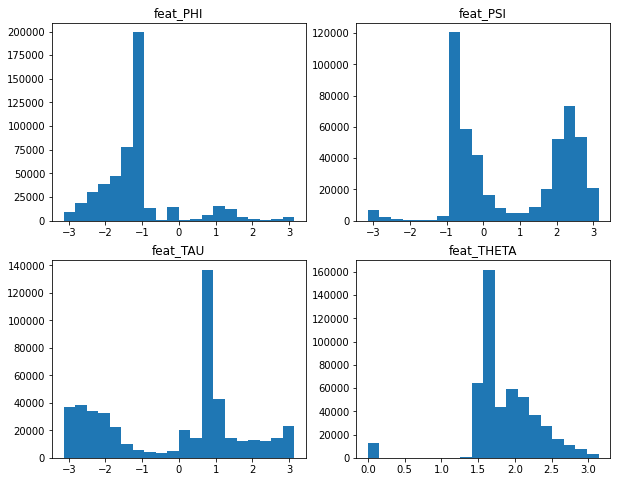

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

axs[0, 0].hist(df_train['feat_PHI'], bins=20)
axs[0, 0].set_title('feat_PHI')

axs[0, 1].hist(df_train['feat_PSI'], bins=20)
axs[0, 1].set_title('feat_PSI')

axs[1, 0].hist(df_train['feat_TAU'], bins=20)
axs[1, 0].set_title('feat_TAU')

axs[1, 1].hist(df_train['feat_THETA'], bins=20)
axs[1, 1].set_title('feat_THETA')



plt.show()

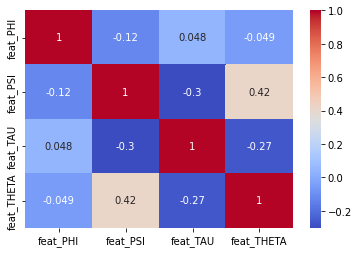

In [ ]:
corr_matrix = df_train[['feat_PHI', 'feat_PSI', 'feat_TAU', 'feat_THETA']].corr()

sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

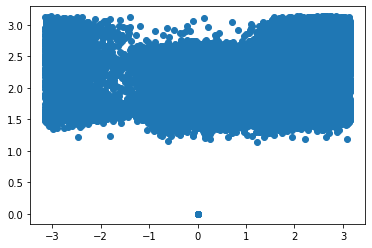

In [ ]:
plt.scatter(df_train['feat_PSI'], df_train['feat_THETA'])
plt.show()

In [ ]:
df_train[['feat_PSI', 'feat_THETA', 'feat_PHI', 'feat_TAU']][(df_train['feat_PSI'] == 0) & (df_train['feat_THETA'] == 0) & (df_train['feat_PHI'] == 0) & (df_train['feat_TAU'] == 0) ]

,feat_PSI,feat_THETA,feat_PHI,feat_TAU
1397,0.0,0.0,0.0,0.0
1398,0.0,0.0,0.0,0.0
1399,0.0,0.0,0.0,0.0
1400,0.0,0.0,0.0,0.0
1401,0.0,0.0,0.0,0.0
...,...,...,...,...
3677,0.0,0.0,0.0,0.0
3678,0.0,0.0,0.0,0.0
3679,0.0,0.0,0.0,0.0
3680,0.0,0.0,0.0,0.0


In [40]:
df_train.duplicated().sum()

0

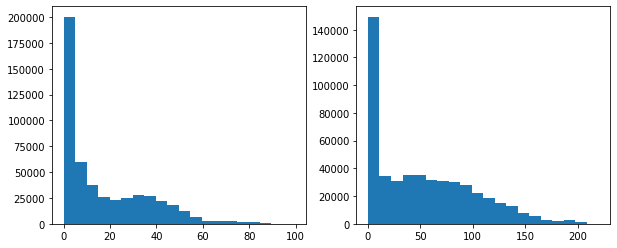

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))
axes[0].hist(df_train['feat_BBSASA'], bins = 20)
axes[1].hist(df_train['feat_SCSASA'], bins = 20)

plt.show()

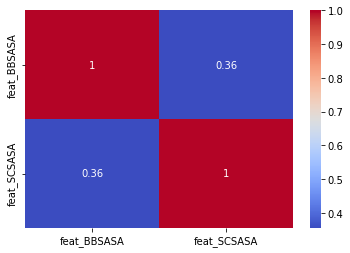

In [46]:
corr_matrix = df_train[['feat_BBSASA', 'feat_SCSASA']].corr()

sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.show()

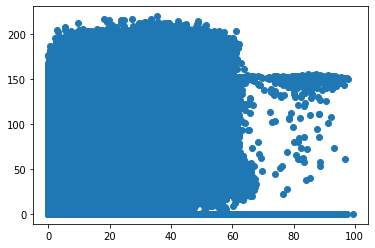

In [47]:
plt.scatter(df_train['feat_BBSASA'], df_train.feat_SCSASA)

#### Check on feat_SCSASA as it has negative values (unexpected)bold text

In [ ]:
df_train[df_train['feat_SCSASA'] < 0].loc[:, ['annotation_sequence', 'annotation_atomrec', 'feat_SCSASA']][['annotation_sequence', 'annotation_atomrec']].value_counts()

annotation_sequence  annotation_atomrec
G                    G                     3287
A                    A                       22
S                    S                       19
V                    V                       17
C                    C                       14
I                    I                        9
L                    L                        7
T                    T                        3
F                    F                        2
W                    W                        2
M                    M                        1
N                    N                        1
Q                    Q                        1
Y                    Y                        1
dtype: int64

In [48]:
df_train.select_dtypes(include = ['int', 'float']).columns

Index(['feat_PHI', 'feat_PSI', 'feat_TAU', 'feat_THETA', 'feat_BBSASA',
       'feat_SCSASA', 'feat_pLDDT', 'feat_DSSP_6', 'feat_DSSP_7',
       'feat_DSSP_8', 'feat_DSSP_9', 'feat_DSSP_10', 'feat_DSSP_11',
       'feat_DSSP_12', 'feat_DSSP_13', 'coord_X', 'coord_Y', 'coord_Z',
       'entry_index'],
      dtype='object')

#### feat_pLDDT

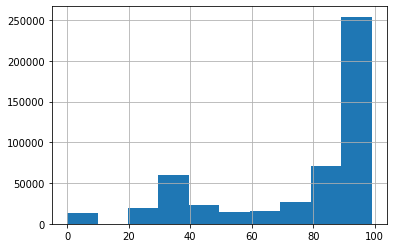

In [50]:
df_train.feat_pLDDT.hist()

#### DSSPs

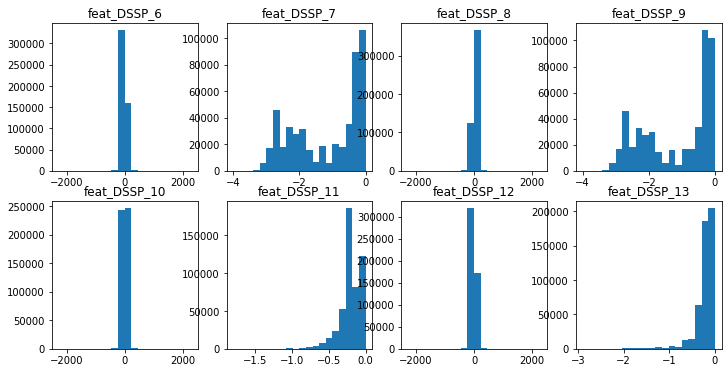

In [51]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.ravel()

for i in range(6, 14):
    ax = axs[i-6]
    ax.hist(df_train[f'feat_DSSP_{i}'], bins=20)
    ax.set_title(f'feat_DSSP_{i}')
plt.show()

### Data Validation on the Categorical Variables

In [ ]:
cat_vars = df_train.select_dtypes(include = ['object', 'bool']).columns
df_train_cat_first_20 = df_train[cat_vars[:20]]
df_train_cat_first_20.describe()


,annotation_sequence,feat_A,feat_C,feat_D,feat_E,feat_F,feat_G,feat_H,feat_I,feat_K,feat_L,feat_M,feat_N,feat_P,feat_Q,feat_R,feat_S,feat_T,feat_V,feat_W
count,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166,497166
unique,20,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,L,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,47881,463159,486801,471671,460675,478840,464826,484821,473109,466173,449285,485454,477976,469042,474280,469543,459010,471282,466053,491210


In [ ]:
df_train_cat_remaining = df_train[cat_vars[20:]]
df_train_cat_remaining.describe()

,feat_Y,annotation_atomrec,feat_DSSP_H,feat_DSSP_B,feat_DSSP_E,feat_DSSP_G,feat_DSSP_I,feat_DSSP_T,feat_DSSP_S,entry,y_Ligand
count,497166,484477,497166,497166,497166,497166,497166,497166,497166,497166,497166
unique,2,20,2,2,2,2,2,2,2,723,2
top,False,L,False,False,False,False,False,False,False,MACF1_HUMAN,False
freq,482944,46400,343915,493464,428549,482016,495072,451028,464548,7385,479912


In [ ]:
df_train['annotation_atomrec'].unique()

array(['M', 'G', 'Q', 'E', 'P', 'R', 'T', 'L', 'S', 'N', 'W', 'Y', 'C',
       'A', 'D', 'V', 'F', 'I', 'H', 'K', nan], dtype=object)

In [ ]:
# check if a letter in annotation_atomrec mean a True in the column named by feat_letter

# Loop through the unique values in the 'annotation_atomrec' column
for letter in df_train['annotation_atomrec'].unique():
    # Check if the 'feat_[letter]' column has a True value for each row
    # where the 'annotation_atomrec' column has the current letter
    if not isinstance(letter, str) and np.isnan(letter):
      print(f'Reached the nan value of annotation_atomrec')
      continue
    if (df_train.loc[df_train['annotation_atomrec'] == letter, 'feat_' + letter] != True).any():
        print(f"There are rows where the 'annotation_atomrec' column has the letter {letter} but the 'feat_{letter}' column does not have a True value.")
    else:
        print(f"All rows where the 'annotation_atomrec' column has the letter {letter} have a True value in the 'feat_{letter}' column.")

All rows where the 'annotation_atomrec' column has the letter M have a True value in the 'feat_M' column.
All rows where the 'annotation_atomrec' column has the letter G have a True value in the 'feat_G' column.
All rows where the 'annotation_atomrec' column has the letter Q have a True value in the 'feat_Q' column.
All rows where the 'annotation_atomrec' column has the letter E have a True value in the 'feat_E' column.
All rows where the 'annotation_atomrec' column has the letter P have a True value in the 'feat_P' column.
All rows where the 'annotation_atomrec' column has the letter R have a True value in the 'feat_R' column.
All rows where the 'annotation_atomrec' column has the letter T have a True value in the 'feat_T' column.
All rows where the 'annotation_atomrec' column has the letter L have a True value in the 'feat_L' column.
All rows where the 'annotation_atomrec' column has the letter S have a True value in the 'feat_S' column.
All rows where the 'annotation_atomrec' column

In [ ]:
v = np.nan
np.isnan(v)

True

## Check for imbalanced dataset

In [ ]:
df_train['y_Ligand'].value_counts()/df_train['y_Ligand'].count()

False    0.965295
True     0.034705
Name: y_Ligand, dtype: float64

## Check for missing values

In [ ]:
df_train.isna().sum()

annotation_sequence        0
feat_A                     0
feat_C                     0
feat_D                     0
feat_E                     0
feat_F                     0
feat_G                     0
feat_H                     0
feat_I                     0
feat_K                     0
feat_L                     0
feat_M                     0
feat_N                     0
feat_P                     0
feat_Q                     0
feat_R                     0
feat_S                     0
feat_T                     0
feat_V                     0
feat_W                     0
feat_Y                     0
annotation_atomrec     12689
feat_PHI                   0
feat_PSI                   0
feat_TAU                   0
feat_THETA                 0
feat_BBSASA                0
feat_SCSASA                0
feat_pLDDT                 0
feat_DSSP_H                0
feat_DSSP_B                0
feat_DSSP_E                0
feat_DSSP_G                0
feat_DSSP_I                0
feat_DSSP_T   

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_train.drop(["y_Ligand"], axis=1), df_train["y_Ligand"], test_size=0.2, random_state=16)

# Feature Engineering
- Converting those DSSP integer data types to float


Build Pipeline